In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt

In [2]:
words = open('names.txt', 'r').read().splitlines()
print(words[:10])

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']


In [3]:
chars = sorted(list(set(''.join(words))))

stoi = {s: i for i, s in enumerate(('.', *chars))}
itos = {i: s for s, i in stoi.items()}
num_classes = len(stoi)

print(itos)

{0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


In [4]:
block_size = 3
X, Y = [], []

for w in words:
    #print(w)
    context = [stoi['.']] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        #print(''.join(itos[i] for i in context), '--->', ch)
        context = context[1:] + [ix]

X = tf.convert_to_tensor(X)
Y = tf.convert_to_tensor(Y)

In [5]:
X.shape, X.dtype, Y.shape, Y.dtype

(TensorShape([228146, 3]), tf.int32, TensorShape([228146]), tf.int32)

In [6]:
embedding_size = 2
hidden_layer_size = 100

C = tf.Variable(tf.random.normal((num_classes, embedding_size)), name='C')
W1 = tf.Variable(tf.random.normal((embedding_size * block_size, hidden_layer_size)), name='W1')
b1 = tf.Variable(tf.zeros(hidden_layer_size, dtype=tf.float32), name='b1')
W2 = tf.Variable(tf.random.normal((hidden_layer_size, num_classes)), name='W2')
b2 = tf.Variable(tf.zeros(num_classes, dtype=tf.float32), name='b2')

parameters = [C, W1, b1, W2, b2]

In [7]:
# GPU is using FP16 for some reason. 
# with tf.device('/CPU:0'):
#     print(tf.one_hot([5], num_classes) @ C)
# print(tf.one_hot([5], num_classes) @ C)
# print(tf.cast(tf.cast(C[5], dtype=tf.float16), dtype=tf.float32))

In [8]:
lossi = []
stepi = []

In [24]:
learning_rate = 0.01
for i in range(10000):
    
    batch_ix = tf.random.uniform(shape=(32,), minval=0, maxval=X.shape[0], dtype=tf.int32)
    X_batch = tf.gather(X, batch_ix)
    Y_batch = tf.gather(Y, batch_ix)

    with tf.GradientTape() as tape:
        emb = tf.gather(C, X_batch)
        h = tf.math.tanh(tf.reshape(emb, (-1, embedding_size * block_size)) @ W1 + b1)
        logits = h @ W2 + b2
        # counts = tf.math.exp(logits)
        # prob = counts / tf.reduce_sum(counts, axis=1, keepdims=True)
        # prob_indexer = tf.stack([tf.range(Y.shape[0]), Y], axis=1)
        # loss = -tf.math.reduce_mean(tf.math.log(tf.gather_nd(prob, prob_indexer)))
        loss = tf.math.reduce_mean(tf.keras.metrics.sparse_categorical_crossentropy(Y_batch, logits, from_logits=True))
        #print(loss.numpy())

    for p, dl_dp in list(zip(parameters, tape.gradient(loss, parameters))):
        # tape.gradient(loss, C) returns IndexedSlices with:
        #   indicies = rows indicies of the embedding lookup table C
        #   values = tensor of gradients for rows in C for  indicies
        # Indicies can contain duplicates so we need to sum the gradients for each index together.
        # This can be done with tf.convert_to_tensor (see example below)
        p.assign_sub(learning_rate*tf.convert_to_tensor(dl_dp))

    lossi.append(loss)
    stepi.append(i)


loss.numpy()

2.6034992

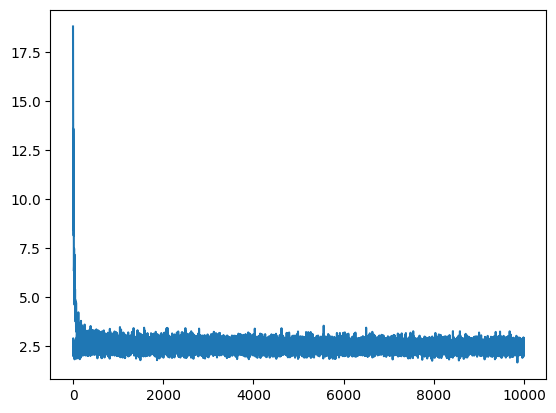

In [19]:
plt.plot(stepi, lossi)

In [25]:
emb = tf.gather(C, X)
h = tf.math.tanh(tf.reshape(emb, (-1, embedding_size * block_size)) @ W1 + b1)
logits = h @ W2 + b2
loss = tf.math.reduce_mean(tf.keras.metrics.sparse_categorical_crossentropy(Y, logits, from_logits=True))
loss.numpy()

2.367621

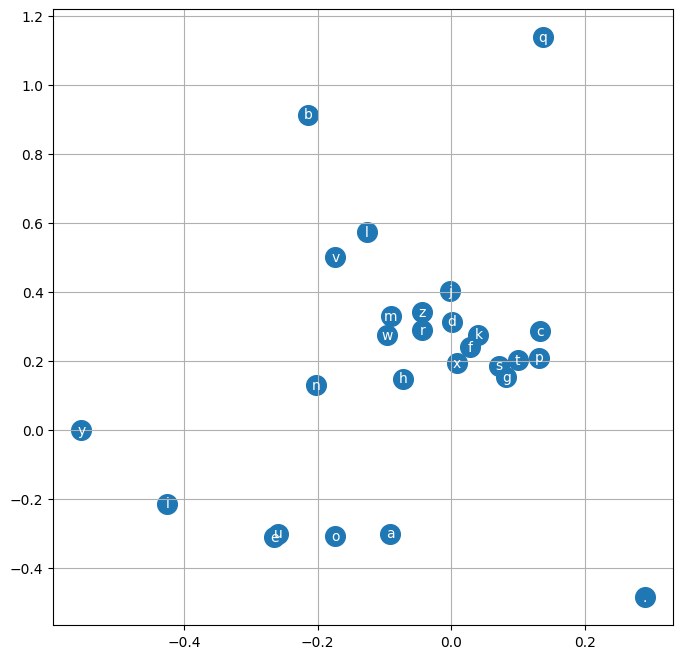

In [26]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].numpy(), C[:,1].numpy(), s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].numpy(), C[i,1].numpy(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [13]:
# convert_to_tensor(IndexedSlices) example

sparse_tensor = tf.IndexedSlices(
    values=[1, 1, 1, 1, 1, 1 ,1], 
    indices=[0, 1, 1, 1, 1, 1, 4], 
    dense_shape=(10,)
)

print(tf.convert_to_tensor(sparse_tensor))

tf.Tensor([1 5 0 0 1 0 0 0 0 0], shape=(10,), dtype=int32)
